In [1]:
from skimage.draw import ellipse
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Make sure that random seed is fixed:

In [2]:
np.random.seed(42)

import os
os.environ['PYTHONHASHSEED'] = '42'

import random as rn

rn.seed(42)

import tensorflow as tf

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.ConfigProto()

from keras import backend as K

tf.set_random_seed(42)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


# Detecting the position of a single ellipse on a noisy background

Define the parameters of the synthetic data-set:

In [3]:
picture_size = 50
picture_channels = 3
evidence_size = 500

Generate one solid ellipse on a random background per image:

In [4]:
from sklearn.model_selection import train_test_split

data_evidence = np.random.rand(evidence_size, picture_size,picture_size, picture_channels)
data_hypotheses_model = np.concatenate((np.random.randint(0,high=picture_size, size=(evidence_size,2)), # position
                                  np.random.rand(evidence_size,2)*6+3,                            # radiuses
                                  np.random.rand(evidence_size,1)*4,                              # rotation
                                  np.random.rand(evidence_size, 3)                                # color
                                 ), axis=1)

def draw_ellipse(data_m, h_model_m):
    data_m_copy = data_m.copy()
    ellipse_cords = ellipse(h_model_m[0], h_model_m[1], h_model_m[2], h_model_m[3],
       shape=(picture_size,picture_size),
       rotation=h_model_m[4])
    
    data_m_copy[ellipse_cords[0], ellipse_cords[1]] = h_model_m[5:8]
    
    return data_m_copy

v_draw_ellipses = np.vectorize(draw_ellipse, signature='(n,n,m),(k)->(n,n,m)')
data_evidence = v_draw_ellipses(data_evidence, data_hypotheses_model)

# only using position as ground-truth to recover with the DL model
data_hypotheses=data_hypotheses_model[:,0:2].astype(int)

onehot_hypotheses = np.zeros((evidence_size,picture_size,picture_size,1))
onehot_hypotheses[np.arange(0,evidence_size), data_hypotheses[:,0], data_hypotheses[:,1],0] = 1

evidence_train, evidence_cv, hypotheses_train, hypotheses_cv, onehot_hypotheses_train, onehot_hypotheses_cv = train_test_split(data_evidence, data_hypotheses, onehot_hypotheses, test_size=0.4)

This is the shape of our data:

In [5]:
print(evidence_train.shape)
print(hypotheses_train.shape)
print(onehot_hypotheses_train.shape)

(300, 50, 50, 3)
(300, 2)
(300, 50, 50, 1)


This is how one sample from our synthetic data-set looks:

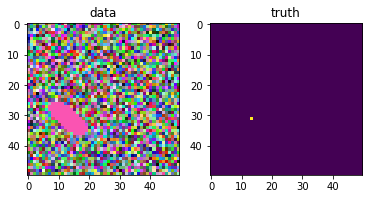

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_idx = 1

fig1, ax1 = plt.subplots()
fig1.add_subplot(121).imshow(evidence_train[sample_idx,:,:,:])
plt.subplot(121).set_title('data')
fig1.add_subplot(122).imshow(onehot_hypotheses_train[sample_idx,:,:,0])
plt.subplot(122).set_title('truth')

Building Keras model.

In [7]:
from keras.layers import Conv2D, Input, BatchNormalization
from keras.models import Model

inputs = Input(shape=(picture_size, picture_size, picture_channels))

conv1_channels = 2
conv1_size = 5
conv1 = Conv2D(conv1_channels, conv1_size, padding="same", activation='relu')(inputs)

bN1 = BatchNormalization()(conv1)

#conv2_channels = 2
#conv2_size = 5
#conv2 = Conv2D(conv2_channels, conv2_size, padding="same", activation='relu')(bN1)

#bN2 = BatchNormalization()(conv2)

#conv3_channels = 1
#conv3_size = 5
#conv3 = Conv2D(conv3_channels, conv3_size, padding="same", activation='relu')(bN2)

#bN3 = BatchNormalization()(conv3)

conv4_channels = 1
conv4_size = 5
conv4 = Conv2D(conv4_channels, conv4_size, padding="same", activation='sigmoid')(bN1)

model = Model(inputs=inputs, outputs=conv4)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 2)         152       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 2)         8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 1)         51        
Total params: 211
Trainable params: 207
Non-trainable params: 4
_________________________________________________________________
None


As expected, predictions made by an untrained model are useless:

In [8]:
hypotheses_predicted = model.predict_on_batch(evidence_cv)

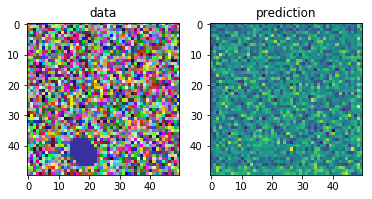

In [9]:
sample_idx = 3
fig2, ax1 = plt.subplots()
fig2.add_subplot(121).imshow(evidence_cv[sample_idx,:,:,:])
plt.subplot(121).set_title('data')
fig2.add_subplot(122).imshow(hypotheses_predicted[sample_idx,:,:,0]/hypotheses_predicted[sample_idx,:,:,0].max())
plt.subplot(122).set_title('prediction')

Let's train for a 100 epochs:

In [10]:
%%time
model.compile(optimizer='adam',
              loss='binary_crossentropy')
model.fit(evidence_train,
          onehot_hypotheses_train,
          epochs=100,
          batch_size=8)

Epoch 1/100
300/300 [==============================] - 2s - loss: 0.7406     
Epoch 2/100
300/300 [==============================] - 1s - loss: 0.6221     
Epoch 3/100
300/300 [==============================] - 1s - loss: 0.4908     
Epoch 4/100
300/300 [==============================] - 1s - loss: 0.3062     
Epoch 5/100
300/300 [==============================] - 1s - loss: 0.1612     
Epoch 6/100
300/300 [==============================] - 1s - loss: 0.0873     
Epoch 7/100
300/300 [==============================] - 1s - loss: 0.0528     
Epoch 8/100
300/300 [==============================] - 1s - loss: 0.0354     
Epoch 9/100
300/300 [==============================] - 1s - loss: 0.0257     
Epoch 10/100
300/300 [==============================] - 1s - loss: 0.0198     
Epoch 11/100
300/300 [==============================] - 1s - loss: 0.0159     
Epoch 12/100
300/300 [==============================] - 1s - loss: 0.0132     
Epoch 13/100
300/300 [==============================] - 1s - 

This model doesn't perform well, unfortunately, even though it looks like it's training:

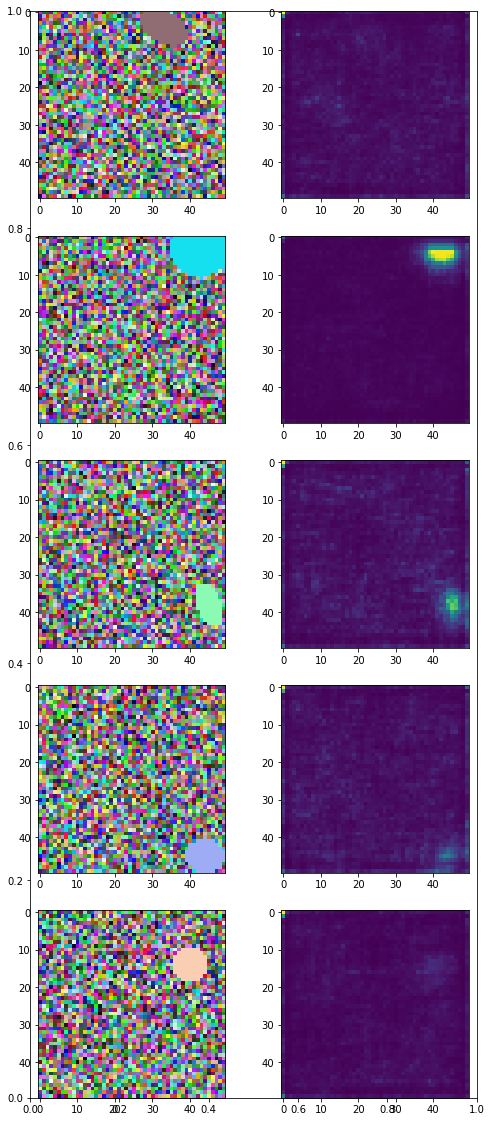

In [11]:
hypotheses_predicted = model.predict_on_batch(evidence_cv)
fig3, ax = plt.subplots()
cv_samples_to_plot = 5
fig3.set_size_inches(8, 4*cv_samples_to_plot)
fig_x = 1
for i in np.random.randint(0, evidence_cv.shape[0], cv_samples_to_plot):
    fig3.add_subplot(cv_samples_to_plot, 2, fig_x).imshow(evidence_cv[i,:,:,:])
    fig3.add_subplot(cv_samples_to_plot, 2, fig_x+1).imshow(hypotheses_predicted[i,:,:,0]/hypotheses_predicted[i,:,:,0].max())
    fig_x = fig_x+2

Moreover, it's burdesome to evaluate it's performance:
- loss function is not intuitive for the task;
- manually evaluating images is boring.

Let's define an intuitive, even though non-differentiable performance metric: the distance from the actual position to argmax of the predicted position of the ellipse. We will use it for evluating the model instead of visual inspection. We can't use it as a training objective (loss function) because it is not differentiable.

In [12]:
import numpy.linalg as LA
def argmax_distance_metric(predicted, true):
    return LA.norm(
        np.array(np.unravel_index(
            np.argmax(predicted.reshape(predicted.shape[0],-1), axis=1),
            (predicted.shape[1], predicted.shape[2])
        )).transpose() -
        true.reshape((true.shape[0], -1)),
        axis=1).mean()

Average distance (in pixels) from ellipse's center to maximum predicted position averaged over CV-set:

In [13]:
print(argmax_distance_metric(hypotheses_predicted, hypotheses_cv))

35.9187106479


We now see that training didn't bring much improvement to the task-performance.

While loss decreased **dramatically**, upstream-performance **doesn't change at all** and is as bad as it can be
(our space has radius of `~35` pixels and this is approximately how far the average max
prediction is from the truth).

There is a problem here:
- Keras reshapes the output treating it as a temporal sequence, and applies the loss function incorrectly.

Model's output has the shape:

In [14]:
model.output.shape

TensorShape([Dimension(None), Dimension(50), Dimension(50), Dimension(1)])

Keras treats it as a single temporal sequence, with 50 frames, each frame being a  `50x1` tensor.

Even by fixing the dimensionality of the output, we are
still presenting a very inbalanced problem to a crossentropy loss-function.

Still, let's fix the output to have more semantic sense:

In [15]:
from keras.layers import Reshape

reshape = Reshape((picture_size*picture_size,))(conv4)
model = Model(inputs=inputs, outputs=reshape)

print(model.summary())
print(model.output.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 2)         152       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 2)         8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 1)         51        
_________________________________________________________________
reshape_1 (Reshape)          (None, 2500)              0         
Total params: 211
Trainable params: 207
Non-trainable params: 4
_________________________________________________________________
None
(?, 2500)


Now, from Keras's perspective, our output is a 2,500-long vector.

Now let's define a more appropriate loss-function, which would better follow the objective, and which still would be differentiable:

In [16]:
smooth = 0.001

def dice_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

One more improvement: we will add a custom callback
to see the changes in our non-differentiable objective (`argmax_distance_metric`).

In [17]:
from keras.callbacks import Callback

class EllipsesCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        hypotheses_predicted = self.model.predict_on_batch(evidence_cv).reshape((evidence_cv.shape[0], picture_size, picture_size, 1))
        print("\nargmax_distance_metric after epoch: %s\n" %argmax_distance_metric(hypotheses_predicted, hypotheses_cv)) 

We will also monitor validation loss, which is now intuitive: Dice coefficient is always between `0` and `2`.

In [18]:
%%time
model.compile(optimizer='adam',
              loss=dice_coef_loss)
model.fit(evidence_train,
          onehot_hypotheses_train.reshape(onehot_hypotheses_train.shape[0],picture_size*picture_size),
          epochs=100,
          batch_size=8,
          callbacks=[EllipsesCallback()],
          validation_data=(evidence_cv, onehot_hypotheses_cv.reshape(onehot_hypotheses_cv.shape[0], picture_size*picture_size)))

Train on 300 samples, validate on 200 samples
Epoch 1/100
296/300 [============================>.] - ETA: 0s - loss: -0.0199
argmax_distance_metric after epoch: 23.9289630703

300/300 [==============================] - 2s - loss: -0.0197 - val_loss: -0.0286
Epoch 2/100
296/300 [============================>.] - ETA: 0s - loss: -0.0297
argmax_distance_metric after epoch: 18.6714086899

300/300 [==============================] - 2s - loss: -0.0298 - val_loss: -0.0302
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: -0.0311
argmax_distance_metric after epoch: 18.3281765653

300/300 [==============================] - 2s - loss: -0.0308 - val_loss: -0.0323
Epoch 4/100
296/300 [============================>.] - ETA: 0s - loss: -0.0322
argmax_distance_metric after epoch: 18.8699517034

300/300 [==============================] - 2s - loss: -0.0320 - val_loss: -0.0344
Epoch 5/100
288/300 [===========================>..] - ETA: 0s - loss: -0.0373
argmax_distance_metric afte

296/300 [============================>.] - ETA: 0s - loss: -0.0414
argmax_distance_metric after epoch: 27.8564097746

300/300 [==============================] - 2s - loss: -0.0408 - val_loss: -0.0085
Epoch 40/100
296/300 [============================>.] - ETA: 0s - loss: -0.0384
argmax_distance_metric after epoch: 18.2102930722

300/300 [==============================] - 2s - loss: -0.0379 - val_loss: -0.0434
Epoch 41/100
296/300 [============================>.] - ETA: 0s - loss: -0.0398
argmax_distance_metric after epoch: 22.403288818

300/300 [==============================] - 2s - loss: -0.0396 - val_loss: -0.0387
Epoch 42/100
296/300 [============================>.] - ETA: 0s - loss: -0.0404
argmax_distance_metric after epoch: 23.5425819599

300/300 [==============================] - 2s - loss: -0.0398 - val_loss: -0.0357
Epoch 43/100
296/300 [============================>.] - ETA: 0s - loss: -0.0376
argmax_distance_metric after epoch: 23.1129059756

300/300 [======================

300/300 [==============================] - 2s - loss: -0.0391 - val_loss: -0.0160
Epoch 78/100
296/300 [============================>.] - ETA: 0s - loss: -0.0474
argmax_distance_metric after epoch: 25.5573653483

300/300 [==============================] - 2s - loss: -0.0467 - val_loss: -0.0252
Epoch 79/100
296/300 [============================>.] - ETA: 0s - loss: -0.0424
argmax_distance_metric after epoch: 25.9945219071

300/300 [==============================] - 2s - loss: -0.0436 - val_loss: -0.0209
Epoch 80/100
296/300 [============================>.] - ETA: 0s - loss: -0.0460
argmax_distance_metric after epoch: 21.2586507175

300/300 [==============================] - 2s - loss: -0.0454 - val_loss: -0.0476
Epoch 81/100
296/300 [============================>.] - ETA: 0s - loss: -0.0458
argmax_distance_metric after epoch: 25.6523512396

300/300 [==============================] - 2s - loss: -0.0454 - val_loss: -0.0350
Epoch 82/100
296/300 [============================>.] - ETA: 0s - 

The model now performs better even after short training, while still very far from perfect.

We can also see that it has the tendency to overfit.

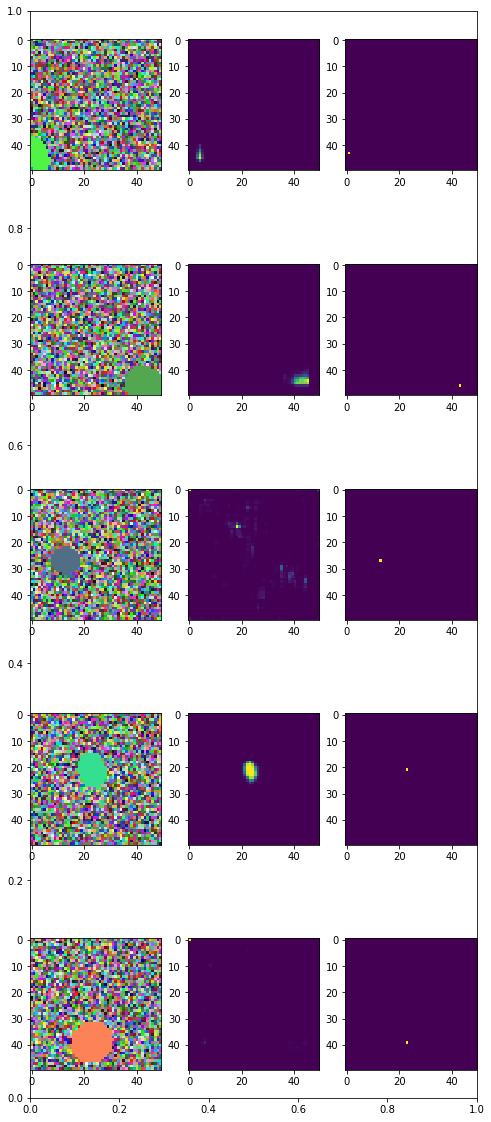

In [21]:
hypotheses_predicted = model.predict_on_batch(evidence_cv).reshape(evidence_cv.shape[0], picture_size, picture_size, 1)
fig4, ax = plt.subplots()
cv_samples_to_plot = 5
fig4.set_size_inches(8, 4*cv_samples_to_plot)
fig_x = 1
for i in np.random.randint(0, evidence_cv.shape[0], cv_samples_to_plot):
    fig4.add_subplot(cv_samples_to_plot, 3, fig_x).imshow(evidence_cv[i,:,:,:])
    fig4.add_subplot(cv_samples_to_plot, 3, fig_x+1).imshow(hypotheses_predicted[i,:,:,0]/hypotheses_predicted[i,:,:,0].max())
    fig4.add_subplot(cv_samples_to_plot, 3, fig_x+2).imshow(onehot_hypotheses_cv[i,:,:,0]/onehot_hypotheses_cv[i,:,:,0].max())
    fig_x = fig_x+3